In [2]:
import warnings                                                   
warnings.filterwarnings('ignore')     
import pandas as pd       
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import xarray as xr
import arviz as az
import watermark
from scipy.special import expit as logistic


from manager_db import *

print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))

/Users/marcelino/dmarcelinobr/pollingpoint
/Users/marcelino/opt/anaconda3/envs/pp-env/lib/python3.8/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollingpoint


In [3]:
# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark

Last updated: 2021-06-17T15:06:18.398859-03:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



## Conexão com o banco de dados

con = sqlite3.connect('pollingpoint.db')

cursor = con.cursor()

cursor.execute("""
UPDATE aprovacao 
SET nome = 'Atlas'
WHERE nome = 'Atlas Político';
""")


# gravando no bd
con.commit()

print('Dados atualizados com sucesso.')

con.close()

In [4]:
con = sqlite3.connect('pollingpoint.db')


file_long = pd.read_sql(""" SELECT * FROM aprovacao;""", con=con) 

con.close()

file_long

,id,data_ini,data_fim,empresa,nome,positiva,regular,negativa,nsnr,erro,ic,amostra,ufs,cidades,partido,presidente,tipo,pergunta,modo,timestamp
0,1,None,1986-03-15,Datafolha,Datafolha,71.0,25.0,2.0,3.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
1,2,None,1987-03-15,Datafolha,Datafolha,33.0,45.0,19.0,3.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
2,3,None,1987-05-15,Datafolha,Datafolha,9.0,35.0,54.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
3,4,None,1987-11-15,Datafolha,Datafolha,11.0,29.0,58.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
4,5,None,1988-03-15,Datafolha,Datafolha,10.0,23.0,65.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,697,None,2021-06-09,Poder360,Poder360,38.0,NaN,54.0,8.0,2.0,95,2500.0,27,522,(Sem partido),Jair Bolsonaro,Aprovação do governo federal,Você aprova ou desaprova o governo do preside...,IVR,2021-06-11 09:20:02
697,698,2021-06-05,2021-06-06,IDEIA Big Data,EXAME/IDEIA,26.0,23.0,49.0,2.0,3.0,95,1252.0,27,None,(Sem partido),Jair Bolsonaro,Avaliação do governo federal,Como você avalia o governo de Jair Bolsonaro a...,CATI,2021-06-11 12:17:35
698,699,2021-06-05,2021-06-06,IDEIA Big Data,EXAME/IDEIA,25.0,23.0,50.0,2.0,3.0,95,1252.0,27,None,(Sem partido),Jair Bolsonaro,Aprovacao do governo federal,Você aprova ou desaprova a maneira como Jair B...,CATI,2021-06-11 12:20:34
699,700,2021-06-07,2021-06-10,Ipespe,Ipespe/XP,34.0,NaN,60.0,6.0,3.2,95,1000.0,24,None,(Sem partido),Jair Bolsonaro,Aprovacao do governo federal,O(a) sr(a) aprova ou desaprova a maneira como ...,CATI,2021-06-11 12:27:47


In [8]:
file_long.groupby(by=['data_fim', 'empresa'],as_index=False).count()

,data_fim,empresa,id,data_ini,nome,positiva,regular,negativa,nsnr,erro,ic,amostra,ufs,cidades,partido,presidente,tipo,pergunta,modo,timestamp
0,1986-03-15,Datafolha,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
1,1987-03-15,Datafolha,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
2,1987-05-15,Datafolha,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
3,1987-11-15,Datafolha,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
4,1988-03-15,Datafolha,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,2021-05-26,Poder360,2,0,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2
604,2021-06-04,Ranking Brasil,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
605,2021-06-06,IDEIA Big Data,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2
606,2021-06-09,Poder360,2,0,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2


In [9]:
file_long.groupby(by=['presidente'],as_index=False).count()

,presidente,id,data_ini,data_fim,empresa,nome,positiva,regular,negativa,nsnr,erro,ic,amostra,ufs,cidades,partido,tipo,pergunta,modo,timestamp
0,Dilma Rousseff I,80,0,80,80,80,80,80,80,80,80,80,46,0,40,80,80,27,80,80
1,Dilma Rousseff II,12,0,12,12,12,12,12,12,12,12,12,12,0,12,12,12,3,12,12
2,Fernando Collor,12,0,12,12,12,12,12,12,12,12,12,3,3,3,12,12,12,12,12
3,Fernando Henrique I,26,0,26,26,26,26,26,26,26,26,26,5,5,5,26,26,24,26,26
4,Fernando Henrique II,64,0,64,64,64,64,64,64,64,64,64,41,42,42,64,64,61,64,64
5,Itamar Franco,17,0,17,17,17,17,17,17,17,17,17,3,0,0,17,17,17,17,17
6,Jair Bolsonaro,327,6,327,327,327,327,249,327,320,327,327,299,134,177,327,327,321,327,327
7,José Sarney,13,0,13,13,13,13,13,13,13,13,13,5,5,5,13,13,13,13,13
8,Lula da Silva I,60,0,60,60,60,60,60,60,60,60,60,41,25,24,60,60,55,60,60
9,Lula da Silva II,49,0,49,49,49,49,49,49,49,49,49,32,1,32,49,49,10,49,49


In [10]:
file_long.groupby(by=['tipo'],as_index=False).count()

,tipo,id,data_ini,data_fim,empresa,nome,positiva,regular,negativa,nsnr,erro,ic,amostra,ufs,cidades,partido,presidente,pergunta,modo,timestamp
0,Aprovacao do governo federal,2,2,2,2,2,2,1,2,2,2,2,2,2,0,2,2,2,2,2
1,Aprovação do governo federal,86,1,86,86,86,86,15,86,81,86,86,86,40,46,86,86,86,86,86
2,Avaliação do governo federal,601,3,601,601,601,601,601,601,598,601,601,429,171,319,601,601,484,601,601
3,Confiança no presidente,6,0,6,6,6,6,0,6,6,6,6,6,0,6,6,6,6,6,6
4,Desempenho pessoal,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
5,Expectativa antes da posse,4,0,4,4,4,4,4,4,4,4,4,3,2,3,4,4,3,4,4
6,Expectativa sobre o futuro,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1


In [16]:
# Tabela pronta para análise:
data = file_long.query("tipo == 'Avaliação do governo federal'")

data

,id,data_ini,data_fim,empresa,nome,positiva,regular,negativa,nsnr,erro,ic,amostra,ufs,cidades,partido,presidente,tipo,pergunta,modo,timestamp
0,1,None,1986-03-15,Datafolha,Datafolha,71.00,25.00,2.0,3.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
1,2,None,1987-03-15,Datafolha,Datafolha,33.00,45.00,19.0,3.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
2,3,None,1987-05-15,Datafolha,Datafolha,9.00,35.00,54.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
3,4,None,1987-11-15,Datafolha,Datafolha,11.00,29.00,58.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
4,5,None,1988-03-15,Datafolha,Datafolha,10.00,23.00,65.0,2.0,3.0,95,NaN,None,None,PMDB,José Sarney,Avaliação do governo federal,"Na sua opinião, o presidente José Sarney está ...",FF,2021-06-11 09:20:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,692,None,2021-05-26,Poder360,Poder360,28.00,13.00,55.0,4.0,2.0,95,2500.0,27,462,(Sem partido),Jair Bolsonaro,Avaliação do governo federal,"De maneira geral, como você avalia o trabalho...",IVR,2021-06-11 09:20:02
693,694,None,2021-06-04,Ranking Brasil,Ranking Brasil,27.37,19.03,51.0,2.6,2.5,95,3000.0,BR,163,(Sem partido),Jair Bolsonaro,Avaliação do governo federal,Como você avalia o governo do presidente Jair ...,CATI,2021-06-11 09:20:02
695,696,None,2021-06-09,Poder360,Poder360,30.00,17.00,52.0,1.0,2.0,95,2500.0,27,522,(Sem partido),Jair Bolsonaro,Avaliação do governo federal,"De maneira geral, como você avalia o trabalho...",IVR,2021-06-11 09:20:02
697,698,2021-06-05,2021-06-06,IDEIA Big Data,EXAME/IDEIA,26.00,23.00,49.0,2.0,3.0,95,1252.0,27,None,(Sem partido),Jair Bolsonaro,Avaliação do governo federal,Como você avalia o governo de Jair Bolsonaro a...,CATI,2021-06-11 12:17:35


In [15]:
pd.crosstab(file_long.empresa, file_long.modo, margins=True)

modo,CATI,FF,IVR,Online,All
empresa,,,,,
Atlas,0,0,0,24,24
CNI/Ibope,0,25,0,0,25
CNT/MDA,0,2,0,0,2
Datafolha,7,193,0,0,200
FSB,3,0,0,0,3
FSB/BTG,1,0,0,0,1
FSB/Veja,4,0,0,0,4
IDEIA Big Data,11,0,0,64,75
IPEC,0,2,0,0,2


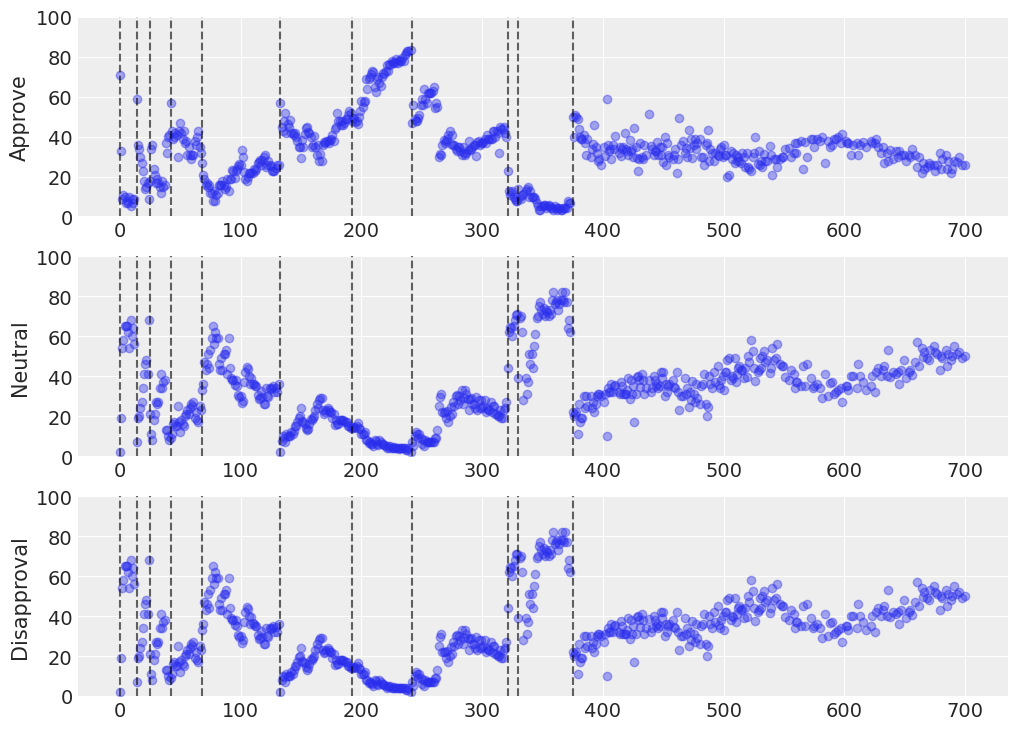

In [27]:

approval_rates = data["positiva"].values
disapproval_rates = data["negativa"].values
neutral_rates = data["negativa"].values

doesnotrespond = 100 - approval_rates - disapproval_rates - neutral_rates

newterm_dates = data.reset_index().groupby("presidente").first()["index"].values
dates = data.index

fig, axes = plt.subplots(3, figsize=(12, 9))
for ax, rate, label in zip(
    axes.ravel(),
    [approval_rates, neutral_rates, disapproval_rates],
    ["Approve", "Neutral", "Disapproval"],
):
    ax.plot(dates, rate, "o", alpha=0.4)
    ax.set_ylim(0, 100)
    ax.set_ylabel(label)
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.6, linestyle="--")



    

In [ ]:
## Desvio-padrão mensal

In [22]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "p_approve"]]
)
rolling_std

KeyError: 'year'

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.p_approve.values,
    "o",
    alpha=0.5,
)
ax.set_title("Monthly standard deviation in polls")
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

In [ ]:
face = data[data["method"] == "face to face"]
dates_face = face.index

other = data[data["method"] != "face to face"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_face, face["p_approve"].values, "o", alpha=0.3, label="face to face")
ax.plot(dates_other, other["p_approve"].values, "o", alpha=0.3, label="other")
ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
ax.set_title("Raw approval polls")
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

## Uma análise crua dos viéses

In [ ]:
data = (
    data.reset_index()
    .merge(
        data.groupby(["year", "month"])["p_approve"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)
data["diff_approval"] = data["p_approve"] - data["p_approve_mean"]
data.round(2)


In [ ]:
POLLSTER_VALS = {
    pollster: data[data["sondage"] == pollster]["diff_approval"].values
    for pollster in list(POLLSTERS)
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

plt.xlabel(r"$p_{approve} - \bar{p}_{approve}$", fontsize=25);
